# WGAN on celeba

In [1]:
%matplotlib inline

import os
import cv2
import pickle
import hashlib
import zipfile
import glob
from tqdm import tqdm
from urllib.request import urlretrieve
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
class Dataset():
    """
    Dataset
    """
    def __init__(self, data_files, width=64, height=64):
        self.width = width
        self.height = height
        self.image_channels = 3
        self.data_files = data_files
        self.shape = len(data_files), self.width, self.height, self.image_channels
        
    def get_image(self, filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.shape[1:3])
        img = img.astype(float)
        img /= 255.0
        img = 2*img - 1.0 # value range -1 to 1
        return img

    def gen_batches(self, batch_size):
        batch = np.zeros(shape=(batch_size, self.height, self.width, self.image_channels), dtype=np.float)
        image_index = 0
        
        while True:
            for batch_index in range(batch_size):
                batch[batch_index, :] = self.get_image(self.data_files[image_index])
                image_index = (image_index + 1) % self.shape[0]
            
            yield batch

## Get celeba data

In [3]:
# Test existence of data
url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
data_path = '../data'
zip_file = 'celeba.zip'
zip_path = os.path.join(data_path, zip_file)
extract_path = os.path.join(data_path, 'img_align_celeba')

exists = { 
    'zip': os.path.exists(zip_path),
    'hash_ok': False,
    'img_folder': os.path.exists(extract_path), 
    'all_imgs': len(glob.glob(extract_path+'/*.jpg')) == 202599
}

if os.path.exists(zip_path):
    exists['hash_ok'] = hashlib.md5(open(zip_path, 'rb').read()).hexdigest() == hash_code

print(exists)

if not exists['all_imgs']:
    # Download zip file, if it does not exist or corrupted
    if not exists['zip'] or not exists['hash_ok']:
        # delete file, if it exists
        os.remove(zip_path)
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(zip_file)) as pbar:
            urlretrieve(url, save_path, pbar.hook)
    # Zip file exists
    # Create folder to unzip, if it does not exist
    if not exists['img_folder']:
        os.makedirs(extract_path)
    # Unzip file
    print('Extracting {}...'.format(zip_file))
    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall(extract_path)

{'zip': False, 'img_folder': True, 'all_imgs': True, 'hash_ok': False}


In [4]:
def view_samples(samples, imshape=(32,32,3)):
    nrows = samples.shape[0]
    ncols = samples.shape[1]
    
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(1.5*ncols,1.5*nrows))
    for ir in range(nrows):
        axrow = axes[ir] if nrows>1 else axes
        for ic in range(ncols):
            img = np.reshape((samples[ir, ic, :]+1)/2.0, imshape)
            axrow[ic].imshow(img, aspect='equal')
            axrow[ic].xaxis.set_visible(False)
            axrow[ic].yaxis.set_visible(False)
            axrow[ic].tick_params(which='both', 
                    bottom='off', top='off', left='off', right='off', 
                    labelbottom='off', labeltop='off', labelleft='off', labelright='off')
            axrow[ic].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)

(8, 32, 32, 3)
(2, 4, 32, 32, 3)


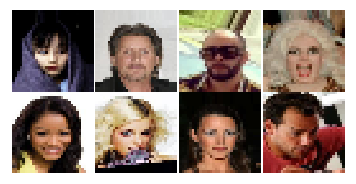

In [5]:
imshape = (32, 32, 3)
celeba = Dataset(data_files=glob.glob(extract_path+'/*.jpg'), width=imshape[0], height=imshape[1])
gen_batches = celeba.gen_batches(8)
batch = next(gen_batches)
print(batch.shape)
batch = np.reshape(batch, (2, 4, *batch.shape[1:]))
print(batch.shape)

view_samples(batch, imshape=imshape)

In [6]:
class WGAN():
    
    def __init__(self, imshape=(32, 32, 3), zshape=(100,), clip=0.01, alpha=0.2, beta1=0.2, smooth=0.9, build=True):
        # sizes
        self.io_shape = imshape
        self.z_shape = zshape
        self.clip = clip
        self.alpha = alpha
        self.beta1 = beta1
        self.smooth = smooth
        
        # graph config
        self.gc = dict()
        
        if build:
            self.build()
            # Save names
            self.set_gc_names()
            
    def placeholders(self):
        self.input = tf.placeholder(tf.float32, shape=[None, *self.io_shape], name='input')
        self.z = tf.placeholder(tf.float32, shape=[None, *self.z_shape], name='z')
        self.lr = tf.placeholder(tf.float32, name='learning_rate')
        
    def generator(self, i, training=True, reuse=False):
        with tf.variable_scope('generator', reuse=reuse):
            layer = tf.contrib.layers.fully_connected(i, 4*4*512, activation_fn=None)
            #layer = tf.maximum(layer, layer * self.alpha)
            # 512
            layer = tf.reshape(layer, (-1, 4, 4, 512))
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 4x4x512
            layer = tf.layers.conv2d_transpose(layer, 256, 3, strides=2, padding='same')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 8x8x256
            layer = tf.layers.conv2d_transpose(layer, 128, 5, strides=2, padding='same')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 16x16x128
            layer = tf.layers.conv2d_transpose(layer, 64, 3, strides=2, padding='same')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 32x32x64
            layer = tf.layers.conv2d_transpose(layer, 3, 5, strides=1, padding='same')
            
            out = tf.tanh(layer)
            
            return out          

    def discriminator(self, X, training=True, reuse=False):
        with tf.variable_scope('discriminator', reuse=reuse):            
            layer = tf.contrib.layers.conv2d(X, num_outputs=64, kernel_size=3, stride=2, padding='SAME')
            layer = tf.maximum(layer, layer * self.alpha)
            # 16x16x64            
            layer = tf.contrib.layers.conv2d(X, num_outputs=128, kernel_size=3, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 8x8x128           
            layer = tf.contrib.layers.conv2d(X, num_outputs=256, kernel_size=5, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 4x4x256
            layer = tf.contrib.layers.flatten(layer)
            # 512
            # 64            
            logits = tf.contrib.layers.fully_connected(layer, 1, activation_fn=None)
            
            return logits   
            
    def build(self):
        self.placeholders()
        
        self.sample_train = self.generator(self.z)
        self.sample = self.generator(self.z, reuse=True, training=False)
        fake_logits = self.discriminator(self.sample_train)
        real_logits = self.discriminator(self.input, reuse=True)
        
        # Loss functions
        dloss_fake = tf.reduce_mean(fake_logits)
        dloss_real = tf.reduce_mean(real_logits)
        self.dloss = dloss_fake - dloss_real
        
        self.gloss = -tf.reduce_mean(fake_logits)
        
        # Trainable parameters
        gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
        dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        
        # Discriminator parameter clipping
        self.op_instclip = [v.assign(tf.clip_by_value(v, -self.clip, self.clip)) for v in dvars]

        # Optimizers
        self.train_discriminator = tf.train.AdamOptimizer(1e-4).minimize(self.dloss, var_list=dvars)
        self.train_generator = tf.train.AdamOptimizer(1e-4).minimize(self.gloss, var_list=gvars)
    
    def set_gc_names(self):
        for k, v in self.__dict__.items():
            if isinstance(v, tf.Tensor) or isinstance(v, tf.Operation):
                self.gc[k] = self.__dict__[k].name
            if isinstance(v, list):
                if all(map(lambda x: isinstance(x, tf.Tensor) or isinstance(x, tf.Operation), v)):
                    self.gc[k] = [_.name for _ in v]
        
    def print_gc_names(self):
        for k, n in self.gc.items():
            print(k, n)
            
    def get_from_graph(self, name, graph):
        try:
            return graph.get_tensor_by_name(name)
        except:
            try:
                return graph.get_operation_by_name(name)
            except:
                raise 
           
    def init_from_graph(self, graph, gc):
        self.gc = gc
        for k, n in self.gc.items():
            if isinstance(n, list):
                self.__dict__[k] = [self.get_from_graph(_, graph) for _ in n]
            else:
                self.__dict__[k] = self.get_from_graph(n, graph)

Epoch  1:   3%|▎         | 6400/202599 [00:25<13:14, 247.09 examples/s, Dloss=-0.1803, Gloss=0.0098] 

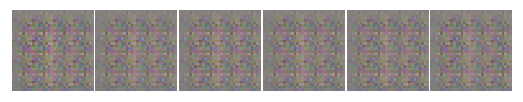

Epoch  1:   6%|▋         | 12800/202599 [00:52<14:55, 211.83 examples/s, Dloss=-0.0529, Gloss=-0.0334]

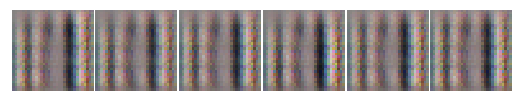

Epoch  1:   9%|▉         | 19200/202599 [01:21<13:27, 227.08 examples/s, Dloss=-0.3352, Gloss=0.1412] 

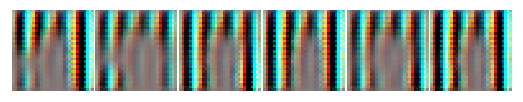

Epoch  1:  13%|█▎        | 25600/202599 [01:50<15:23, 191.64 examples/s, Dloss=-0.0278, Gloss=-0.0378]

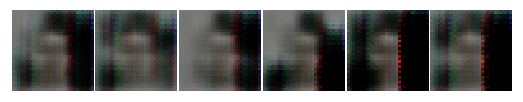

Epoch  1:  16%|█▌        | 32000/202599 [02:18<12:05, 235.22 examples/s, Dloss=-0.0900, Gloss=0.0163] 

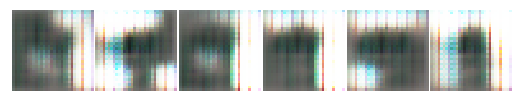

Epoch  1:  19%|█▉        | 38400/202599 [02:46<11:35, 236.22 examples/s, Dloss=-0.1616, Gloss=0.0343] 

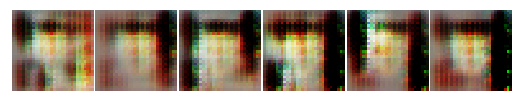

Epoch  1:  22%|██▏       | 44800/202599 [03:14<11:11, 234.90 examples/s, Dloss=-0.5077, Gloss=0.5660] 

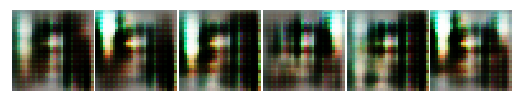

Epoch  1:  25%|██▌       | 51200/202599 [03:42<10:41, 236.16 examples/s, Dloss=0.1522, Gloss=-0.2619] 

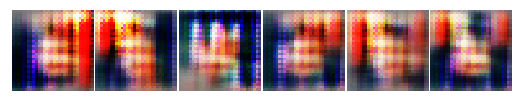

Epoch  1:  28%|██▊       | 57600/202599 [04:10<10:54, 221.70 examples/s, Dloss=-0.1034, Gloss=-0.0295]

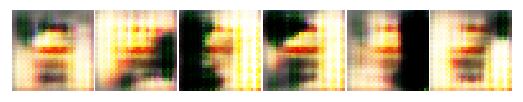

Epoch  1:  32%|███▏      | 64000/202599 [04:39<10:26, 221.23 examples/s, Dloss=-0.3117, Gloss=0.2939] 

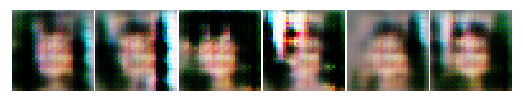

Epoch  1:  35%|███▍      | 70400/202599 [05:09<09:56, 221.62 examples/s, Dloss=-0.4008, Gloss=0.3780]

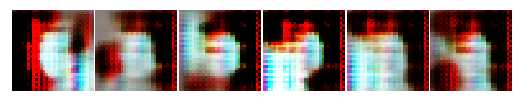

Epoch  1:  38%|███▊      | 76800/202599 [05:39<09:53, 212.06 examples/s, Dloss=-0.5653, Gloss=0.7119]

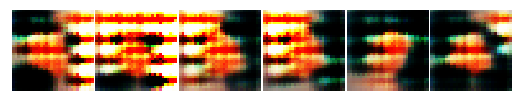

Epoch  1:  41%|████      | 83200/202599 [06:09<09:13, 215.67 examples/s, Dloss=-0.5178, Gloss=0.3510]

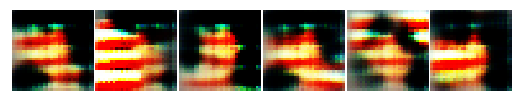

Epoch  1:  44%|████▍     | 89600/202599 [06:39<08:48, 213.78 examples/s, Dloss=-0.4977, Gloss=0.3743] 

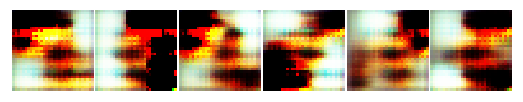

Epoch  1:  47%|████▋     | 96000/202599 [07:09<08:13, 215.89 examples/s, Dloss=0.2574, Gloss=0.0364] 

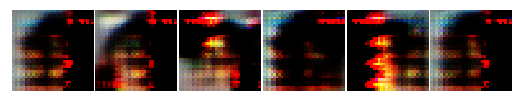

Epoch  1:  51%|█████     | 102400/202599 [07:40<07:47, 214.28 examples/s, Dloss=-0.3542, Gloss=0.5708]

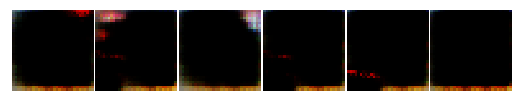

Epoch  1:  54%|█████▎    | 108800/202599 [08:10<07:18, 214.01 examples/s, Dloss=-0.1365, Gloss=0.3832]

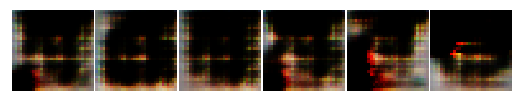

Epoch  1:  57%|█████▋    | 115200/202599 [08:40<06:50, 212.71 examples/s, Dloss=-0.1817, Gloss=0.2653]

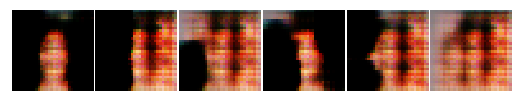

Epoch  1:  60%|██████    | 121600/202599 [09:10<06:14, 216.27 examples/s, Dloss=0.0146, Gloss=0.1801] 

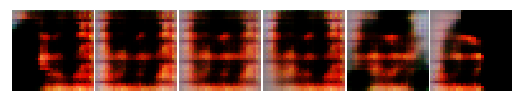

Epoch  1:  63%|██████▎   | 128000/202599 [10:30<17:50, 69.71 examples/s, Dloss=-0.3571, Gloss=0.6492] 

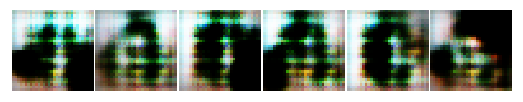

Epoch  1:  66%|██████▋   | 134400/202599 [11:58<15:04, 75.44 examples/s, Dloss=-0.5421, Gloss=0.4231]

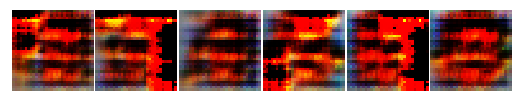

Epoch  1:  69%|██████▉   | 140800/202599 [13:25<14:00, 73.57 examples/s, Dloss=-0.4163, Gloss=0.4596] 

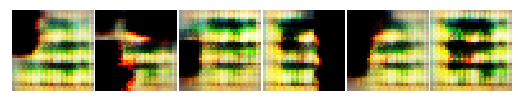

Epoch  1:  73%|███████▎  | 147200/202599 [14:52<12:34, 73.47 examples/s, Dloss=-0.6335, Gloss=0.4536]

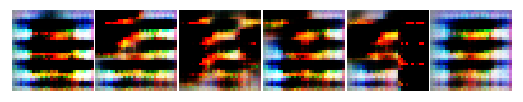

Epoch  1:  76%|███████▌  | 153600/202599 [16:20<11:11, 72.94 examples/s, Dloss=-0.0411, Gloss=0.0875] 

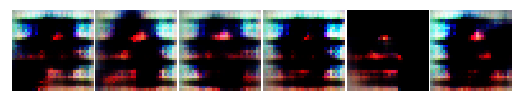

Epoch  1:  79%|███████▉  | 160000/202599 [17:47<09:28, 74.88 examples/s, Dloss=0.0001, Gloss=-0.0537] 

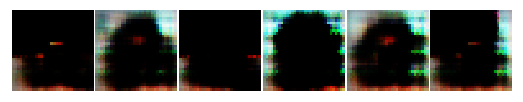

Epoch  1:  82%|████████▏ | 166400/202599 [19:16<08:15, 73.01 examples/s, Dloss=-0.7515, Gloss=0.5696] 

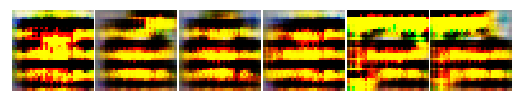

Epoch  1:  85%|████████▌ | 172800/202599 [20:43<06:42, 74.10 examples/s, Dloss=-0.2425, Gloss=0.1901] 

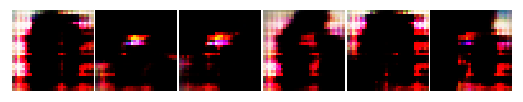

Epoch  1:  88%|████████▊ | 179200/202599 [22:10<05:15, 74.18 examples/s, Dloss=-0.2109, Gloss=0.0482] 

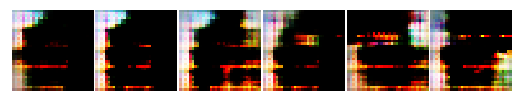

Epoch  1:  92%|█████████▏| 185600/202599 [23:36<03:50, 73.74 examples/s, Dloss=-0.1128, Gloss=0.3563]

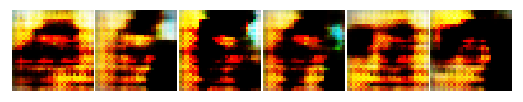

Epoch  1:  95%|█████████▍| 192000/202599 [25:04<02:26, 72.43 examples/s, Dloss=-0.2639, Gloss=0.3501] 

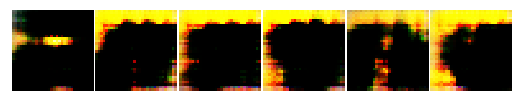

Epoch  1:  98%|█████████▊| 198400/202599 [26:31<00:56, 74.20 examples/s, Dloss=-0.2059, Gloss=0.1339] 

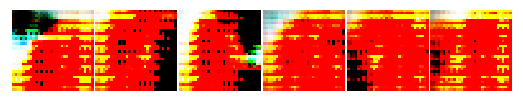

Epoch  1: 100%|█████████▉| 202592/202599 [27:28<00:00, 72.06 examples/s, Dloss=-0.2525, Gloss=-0.0441]


In [13]:
# Train the model and save it
imshape=(32, 32, 3)
zshape=(100,)
celeba = Dataset(data_files=glob.glob(extract_path+'/*.jpg'), width=imshape[0], height=imshape[1])
batch_size = 32
nepochs = 1
learning_rate = 5e-5
discriminator_train_steps = 1
display_every = 200
restore_model = False # False, True
gen_batches = celeba.gen_batches(batch_size)

tf.reset_default_graph()
if restore_model:    
    model = WGAN(imshape=imshape, zshape=zshape, build=False)    
else:
    model = WGAN(imshape=imshape, zshape=zshape)
    with open('chck/dcgan_celeba.pickle', 'wb') as f:
        pickle.dump(model.gc, f)

with tf.Session() as sess:
    if restore_model:
        saver = tf.train.import_meta_graph('chck/dcgan_celeba.meta')
        saver.restore(sess, "chck/dcgan_celeba")
        with open('chck/dcgan_celeba.pickle', 'rb') as f:
            gc = pickle.load(f) 
        model.init_from_graph(sess.graph, gc)
    else:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

    num_examples = celeba.shape[0]//1
    with tqdm(desc='Epoch', total=num_examples*nepochs, unit=' examples') as pbar:
        dloss, gloss = 0.0, 0.0
        dlosses, glosses = [], []
        samples = []
        for epoch in range(nepochs):
            for batch_idx in range(int(num_examples//batch_size)):
                # Image batch
                batch = next(gen_batches)
                # Noise batch
                noise_batch = np.random.uniform(-1.0, 1.0, size=(batch_size, *model.z_shape))

                # Train discriminator
                _, _, dloss = sess.run([model.train_discriminator, model.op_instclip, model.dloss], 
                                feed_dict={model.input: batch, model.z: noise_batch, model.lr: learning_rate})
                # Train generator
                if batch_idx % discriminator_train_steps == (discriminator_train_steps-1):
                    _, gloss = sess.run([model.train_generator, model.gloss], 
                                feed_dict={model.z: noise_batch, model.lr: learning_rate})                
                
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                pbar.set_postfix(Dloss='{:.4f}'.format(dloss), 
                                Gloss='{:.4f}'.format(gloss))
                
                if batch_idx % display_every == (display_every - 1):
                    noise_batch = np.random.uniform(-1.0, 1.0, size=(6, *model.z_shape))
                    s = sess.run(model.sample, feed_dict={model.z: noise_batch})
                    s = np.array(s)
                    s = s[np.newaxis,:]
                    view_samples(s, imshape=(32, 32, 3))
                    plt.show()                    
        
            # Save discriminator and generator losses
            dlosses.append(dloss)
            glosses.append(gloss)
            
            # Generate samples
            noise_batch = np.random.uniform(-1.0, 1.0, size=(batch_size, *model.z_shape))
            s = sess.run(model.sample, feed_dict={model.z: noise_batch})
            samples.append(s)          

    save_path = saver.save(sess, "chck/dcgan_celeba")

with open('chck/dcgan_celeba_samples.pickle', 'wb') as f:
    pickle.dump(np.array(samples), f)